# Generating new cartoon images

Following this [DataCamp tutorial](https://www.datacamp.com/community/tutorials/generative-adversarial-networks)

## Import packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


## Set some variables

In [2]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

## Create the generator and discriminator networks

In [4]:
# You will use the Adam optimizer

shape = (256, 256)
num_pixels = shape[0] * shape[1]

def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(num_pixels, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=num_pixels, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

## Combine the generator and discriminator into a GAN

In [5]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

## Save training progress updates

In [6]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, shape, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, shape[0], shape[1])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_cartoons_generated_image_epoch_%d.png' % epoch)

# Train the network

In [8]:
import cv2
import pandas as pd

In [9]:
df = pd.read_json("./cartoons.json")
df.drop_duplicates(inplace=True)
df.set_index("id", inplace=True)
print(df.shape)
df.head(3)

(1493, 6)


caption  \
id                                                           
2831481  “Please compliment Stewart on the firewood. He...   
1550951  “Russ is the sort of person who never wants to...   
2922743                                                      

                                               caption_raw  \
id                                                           
2831481  &ldquo;Please compliment Stewart on the firewo...   
1550951  &ldquo;Russ is the sort of person who never wa...   
2922743                                                      

                                          cartoon_bank_url  \
id                                                           
2831481                                                      
1550951                                                      
2922743  http://www.condenaststore.com/-sp/_i13010768_.htm   

                       date      pn  \
id                                    
2831481 2014-09-16 14:20:00    aa39   
1550951 2014-07-14 00:10:00  a18048   
2922743 2014-12-05 14:36:00  a18714   

                                                       src  
id                                                          
2831481  https://www.newyorker.com/wp-content/uploads/1...  
1550951  https://www.newyorker.com/wp-content/uploads/2...  
2922743  https://www.newyorker.com/wp-content/uploads/2...

In [28]:
def load_images(shape=(128, 128)):
    images = np.ndarray((len(df), shape[0], shape[1]))
    for n, idx in enumerate(df.index):
        fn = f"./images/{idx}.jpg"
        try:                        
            im = cv2.imread(fn, 0) # Read image as grayscale
            images[n, :] = cv2.resize(im, shape)
        except:
            pass
#             print(f"Skipping {fn}")
    return images

In [29]:
def process_cartoons_for_training(images):
    """Normalizes image values and converts to row vectors"""
    scaler = images.max() / 2
    
    # Normalize our images to be in the range[-1, 1]
    images = (images.astype(np.float32) - scaler) / scaler
    
    # Convert images to row vectors
    nc = images.shape[1] * images.shape[2]
    images = images.reshape(images.shape[0], nc)
    return images

In [30]:
def load_cartoon_data(shape):
    """Loads and normalizes cartoons for GAN training"""
    images = load_images(shape)
    processed = process_cartoons_for_training(images)
    return processed

In [31]:
def displayCartoon(cartoon, figsize=(8, 8)):
    """Displays an image with caption from a row of the DataFrame"""
    fn = f"./images/{cartoon.name}.{cartoon.src.split('.')[-1]}"
    image = plt.imread(fn)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image, cmap="gray")
    ax.set(**{"xticks": [], "yticks": []})
    ax.set_xlabel("\n" + cartoon.caption, fontsize=16)
    plt.show()

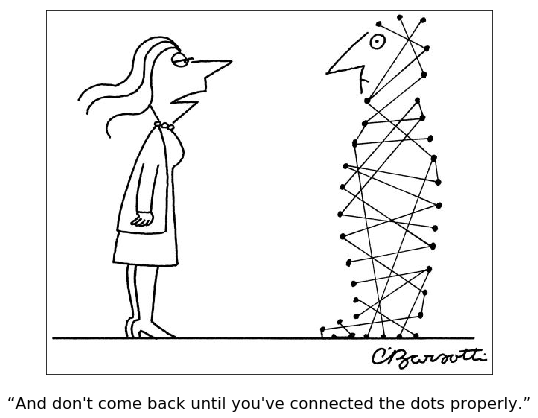

In [206]:
displayCartoon(df.sample(1).iloc[0])

In [27]:
# Get the training and testing data
x_train = load_cartoon_data(shape)

Skipping ./images/2661042.jpg
Skipping ./images/2661132.jpg
Skipping ./images/2716041.jpg
Skipping ./images/2659142.jpg
Skipping ./images/2659202.jpg
Skipping ./images/2660862.jpg
Skipping ./images/2661012.jpg
Skipping ./images/2808463.jpg
Skipping ./images/2659172.jpg
Skipping ./images/2646242.jpg
Skipping ./images/2717801.jpg
Skipping ./images/2660952.jpg
Skipping ./images/2811027.jpg
Skipping ./images/2709823.jpg
Skipping ./images/2659342.jpg
Skipping ./images/2646272.jpg
Skipping ./images/2661102.jpg
Skipping ./images/2659262.jpg
Skipping ./images/2661072.jpg
Skipping ./images/2714057.jpg
Skipping ./images/2659232.jpg
Skipping ./images/2660922.jpg
Skipping ./images/2659062.jpg
Skipping ./images/2709705.jpg
Skipping ./images/2660982.jpg
Skipping ./images/2807253.jpg
Skipping ./images/2659112.jpg
Skipping ./images/2809519.jpg
Skipping ./images/2660892.jpg
Skipping ./images/2660832.jpg
Skipping ./images/2714939.jpg


In [36]:
def train(x_train, epochs=1, batch_size=128):
    t0 = time.time()
    t1 = time.time()
    im_shape = 2 * [int(np.sqrt(x_train.shape[1]))]

    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        print(f"Time since last epoch: {(time.time() - t1) / 60:.2f} minutes.")
        t1 = time.time()
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake New Yorker cartoon images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 5 == 0 or e == epochs:
            plot_generated_images(e, generator, im_shape)
    print(f"\nDone. Total time: {(time.time() - t0) / 60:.2f} minutes.")
    
    return gan, discriminator, y_gen

  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Time since last epoch: 0.01 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------
Time since last epoch: 3.22 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------
Time since last epoch: 2.58 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------
Time since last epoch: 2.53 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------
Time since last epoch: 2.74 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------
Time since last epoch: 2.79 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 11 ---------------
Time since last epoch: 2.64 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 12 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 13 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 14 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 15 ---------------
Time since last epoch: 2.40 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 16 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 17 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 18 ---------------
Time since last epoch: 2.49 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 19 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 20 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 21 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 22 ---------------
Time since last epoch: 2.53 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 23 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 24 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 25 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 26 ---------------
Time since last epoch: 2.63 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 27 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 28 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 29 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 30 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 31 ---------------
Time since last epoch: 2.67 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 32 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 33 ---------------
Time since last epoch: 2.53 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 34 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 35 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 36 ---------------
Time since last epoch: 2.58 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 37 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 38 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 39 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 40 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 41 ---------------
Time since last epoch: 2.61 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 42 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 43 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 44 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 45 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 46 ---------------
Time since last epoch: 2.60 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 47 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 48 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 49 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 50 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 51 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 52 ---------------
Time since last epoch: 2.40 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 53 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 54 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 55 ---------------
Time since last epoch: 2.54 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 56 ---------------
Time since last epoch: 2.61 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 57 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 58 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 59 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 60 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 61 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 62 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 63 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 64 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 65 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 66 ---------------
Time since last epoch: 2.54 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 67 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 68 ---------------
Time since last epoch: 2.40 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 69 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 70 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 71 ---------------
Time since last epoch: 2.60 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 72 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 73 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 74 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 75 ---------------
Time since last epoch: 2.49 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 76 ---------------
Time since last epoch: 2.68 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 77 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 78 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 79 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 80 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 81 ---------------
Time since last epoch: 2.54 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 82 ---------------
Time since last epoch: 2.40 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 83 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 84 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 85 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 86 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 87 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 88 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 89 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 90 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 91 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 92 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 93 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 94 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 95 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 96 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 97 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 98 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 99 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 100 ---------------
Time since last epoch: 2.41 minutes.


100%|██████████| 11/11 [02:24<00:00, 13.23s/it]
/Users/john/.virtualenvs/newyorker/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 101 ---------------
Time since last epoch: 2.63 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 102 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 103 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 104 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 105 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 106 ---------------
Time since last epoch: 2.54 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 107 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 108 ---------------
Time since last epoch: 2.40 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 109 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 110 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 111 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 112 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 113 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 114 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 115 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 116 ---------------
Time since last epoch: 2.64 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 117 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 118 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 119 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 120 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 121 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 122 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 123 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 124 ---------------
Time since last epoch: 2.50 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 125 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 126 ---------------
Time since last epoch: 2.57 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 127 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 128 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 129 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 130 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 131 ---------------
Time since last epoch: 2.65 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 132 ---------------
Time since last epoch: 2.50 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 133 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 134 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 135 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 136 ---------------
Time since last epoch: 2.60 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 137 ---------------
Time since last epoch: 2.53 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 138 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 139 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 140 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 141 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 142 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 143 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 144 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 145 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 146 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 147 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 148 ---------------
Time since last epoch: 2.49 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 149 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 150 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 151 ---------------
Time since last epoch: 2.53 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 152 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 153 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 154 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 155 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 156 ---------------
Time since last epoch: 2.57 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 157 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 158 ---------------
Time since last epoch: 2.49 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 159 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 160 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 161 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 162 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 163 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 164 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 165 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 166 ---------------
Time since last epoch: 2.68 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 167 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 168 ---------------
Time since last epoch: 2.52 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 169 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 170 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 171 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 172 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 173 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 174 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 175 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 176 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 177 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 178 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 179 ---------------
Time since last epoch: 2.58 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 180 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 181 ---------------
Time since last epoch: 2.57 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 182 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 183 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 184 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 185 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 186 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 187 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 188 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 189 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 190 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 191 ---------------
Time since last epoch: 2.54 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 192 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 193 ---------------
Time since last epoch: 2.52 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 194 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 195 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 196 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 197 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 198 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 199 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 200 ---------------
Time since last epoch: 2.52 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 201 ---------------
Time since last epoch: 2.58 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 202 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 203 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 204 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 205 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 206 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 207 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 208 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 209 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 210 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 211 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 212 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 213 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 214 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 215 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 216 ---------------
Time since last epoch: 2.73 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 217 ---------------
Time since last epoch: 2.58 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 218 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 219 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 220 ---------------
Time since last epoch: 2.51 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 221 ---------------
Time since last epoch: 2.62 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 222 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 223 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 224 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 225 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 226 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 227 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 228 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 229 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 230 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 231 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 232 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 233 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 234 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 235 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 236 ---------------
Time since last epoch: 2.54 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 237 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 238 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 239 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 240 ---------------
Time since last epoch: 2.50 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 241 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 242 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 243 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 244 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 245 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 246 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 247 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 248 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 249 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 250 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 251 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 252 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 253 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 254 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 255 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 256 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 257 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 258 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 259 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 260 ---------------
Time since last epoch: 2.53 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 261 ---------------
Time since last epoch: 2.57 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 262 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 263 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 264 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 265 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 266 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 267 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 268 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 269 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 270 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 271 ---------------
Time since last epoch: 2.84 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 272 ---------------
Time since last epoch: 2.53 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 273 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 274 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 275 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 276 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 277 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 278 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 279 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 280 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 281 ---------------
Time since last epoch: 2.63 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 282 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 283 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 284 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 285 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 286 ---------------
Time since last epoch: 2.57 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 287 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 288 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 289 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 290 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 291 ---------------
Time since last epoch: 2.58 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 292 ---------------
Time since last epoch: 2.42 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 293 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 294 ---------------
Time since last epoch: 2.41 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 295 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 296 ---------------
Time since last epoch: 2.57 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 297 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 298 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 299 ---------------
Time since last epoch: 2.88 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 300 ---------------
Time since last epoch: 14.66 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 301 ---------------
Time since last epoch: 2.61 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 302 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 303 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 304 ---------------
Time since last epoch: 2.50 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 305 ---------------
Time since last epoch: 2.50 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 306 ---------------
Time since last epoch: 2.65 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 307 ---------------
Time since last epoch: 3.02 minutes.


 91%|█████████ | 10/11 [05:06<00:35, 35.92s/it]

KeyboardInterrupt: 

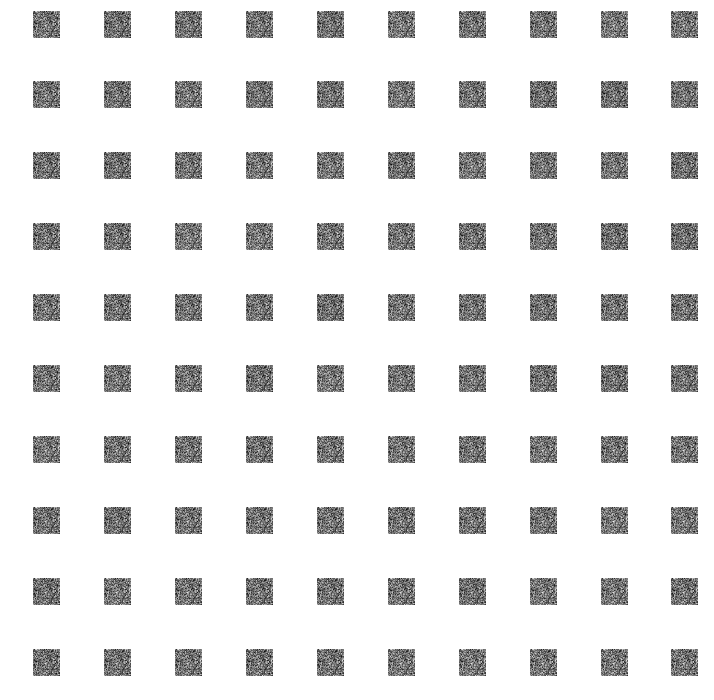

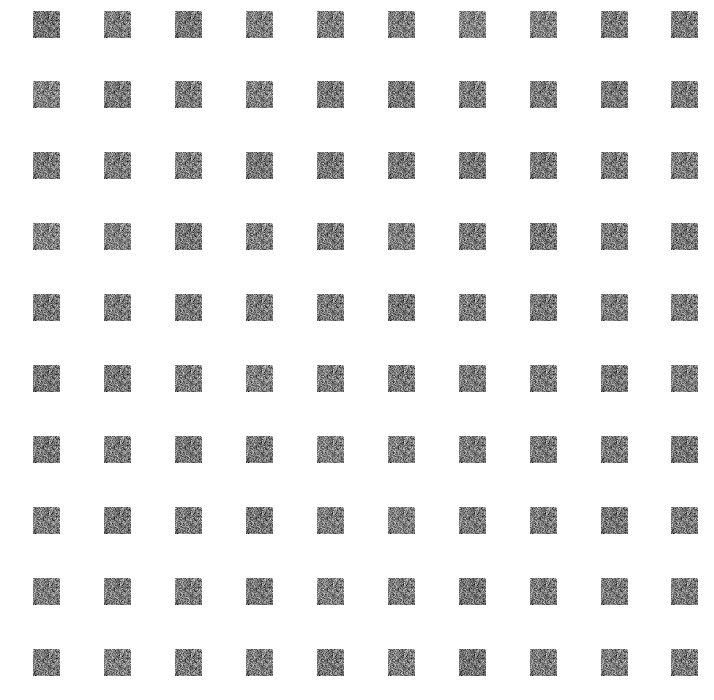

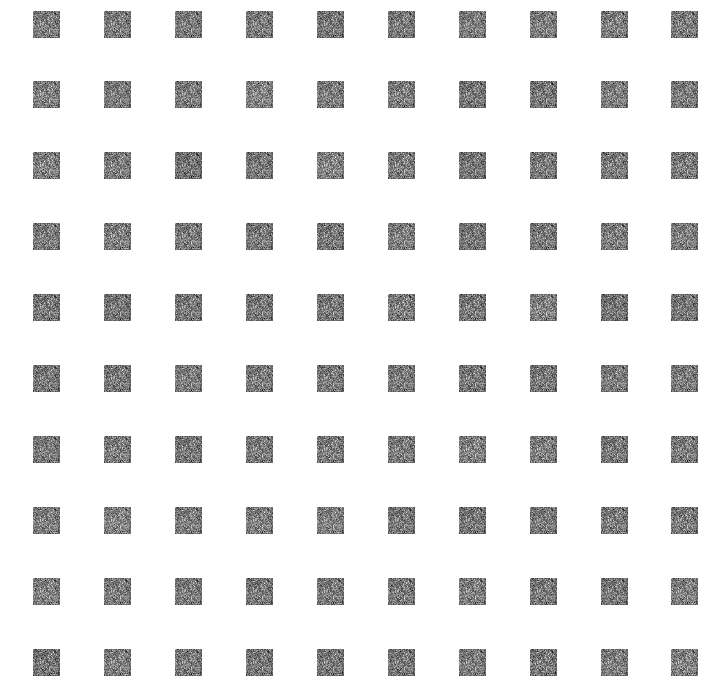

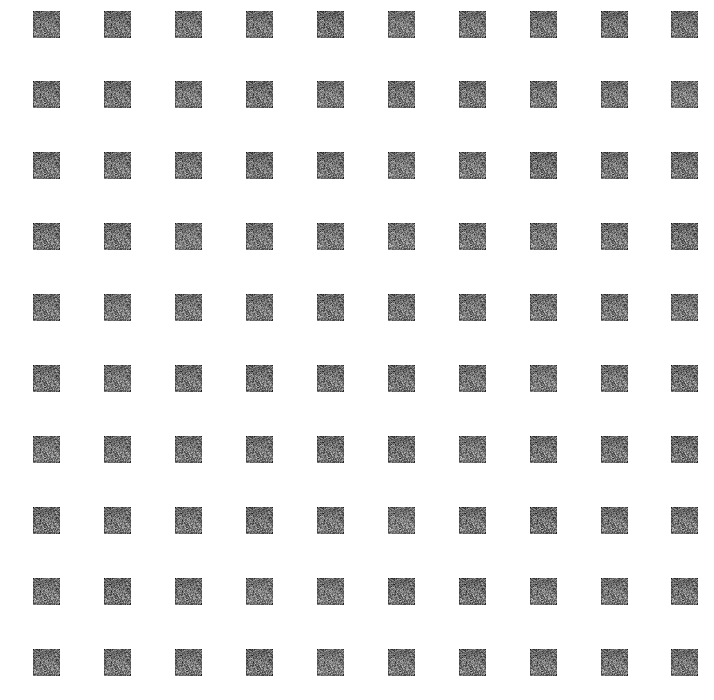

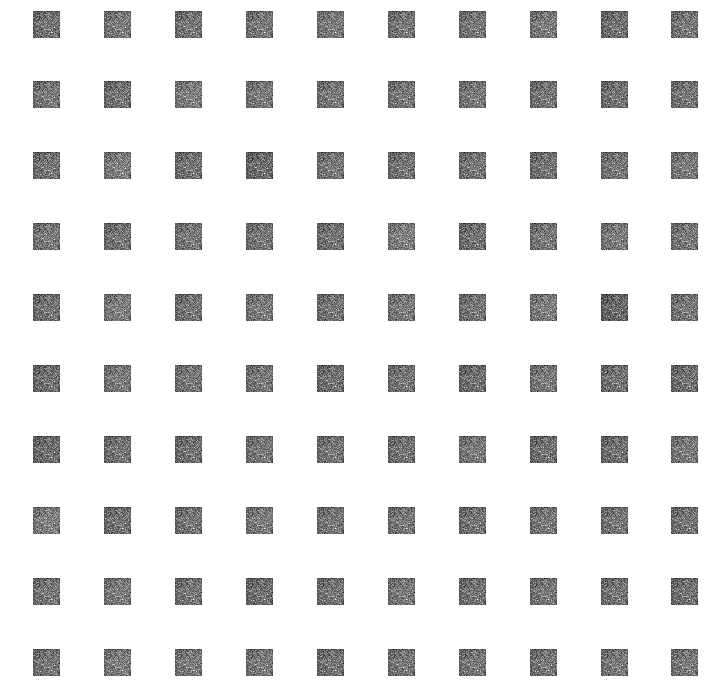

Exception ignored in: <bound method tqdm.__del__ of  91%|█████████ | 10/11 [07:59<00:35, 35.92s/it]>
Traceback (most recent call last):
  File "/Users/john/.virtualenvs/newyorker/lib/python3.6/site-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/Users/john/.virtualenvs/newyorker/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/Users/john/.virtualenvs/newyorker/lib/python3.6/site-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/Users/john/.virtualenvs/newyorker/lib/python3.6/site-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


In [ ]:
%%time
out = train(x_train, 500, 128)

  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Time since last epoch: 0.01 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------
Time since last epoch: 3.39 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------
Time since last epoch: 2.58 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------
Time since last epoch: 2.81 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------
Time since last epoch: 2.73 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------
Time since last epoch: 2.71 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------
Time since last epoch: 3.02 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------
Time since last epoch: 3.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 11 ---------------
Time since last epoch: 2.92 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 12 ---------------
Time since last epoch: 2.80 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 13 ---------------
Time since last epoch: 2.57 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 14 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 15 ---------------
Time since last epoch: 2.53 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 16 ---------------
Time since last epoch: 3.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 17 ---------------
Time since last epoch: 2.70 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 18 ---------------
Time since last epoch: 2.60 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 19 ---------------
Time since last epoch: 2.55 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 20 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 21 ---------------
Time since last epoch: 2.77 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 22 ---------------
Time since last epoch: 2.52 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 23 ---------------
Time since last epoch: 2.51 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 24 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 25 ---------------
Time since last epoch: 2.48 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 26 ---------------
Time since last epoch: 2.61 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 27 ---------------
Time since last epoch: 2.37 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 28 ---------------
Time since last epoch: 2.36 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 29 ---------------
Time since last epoch: 2.38 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 30 ---------------
Time since last epoch: 2.36 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 31 ---------------
Time since last epoch: 2.64 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 32 ---------------
Time since last epoch: 2.67 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 33 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 34 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 35 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 36 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 37 ---------------
Time since last epoch: 2.45 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 38 ---------------
Time since last epoch: 2.46 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 39 ---------------
Time since last epoch: 2.64 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 40 ---------------
Time since last epoch: 2.53 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 41 ---------------
Time since last epoch: 2.59 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 42 ---------------
Time since last epoch: 2.75 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 43 ---------------
Time since last epoch: 2.54 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 44 ---------------
Time since last epoch: 2.71 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 45 ---------------
Time since last epoch: 2.40 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 46 ---------------
Time since last epoch: 2.56 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 47 ---------------
Time since last epoch: 2.47 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 48 ---------------
Time since last epoch: 2.43 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 49 ---------------
Time since last epoch: 2.44 minutes.


  0%|          | 0/11 [00:00<?, ?it/s]

--------------- Epoch 50 ---------------
Time since last epoch: 2.45 minutes.


100%|██████████| 11/11 [02:27<00:00, 13.36s/it]



Done. Total time: 131.14 minutes.


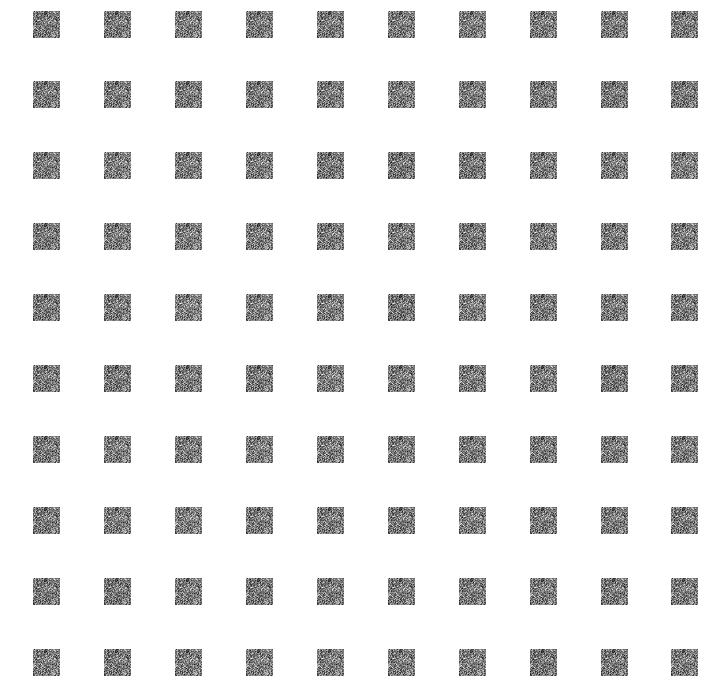

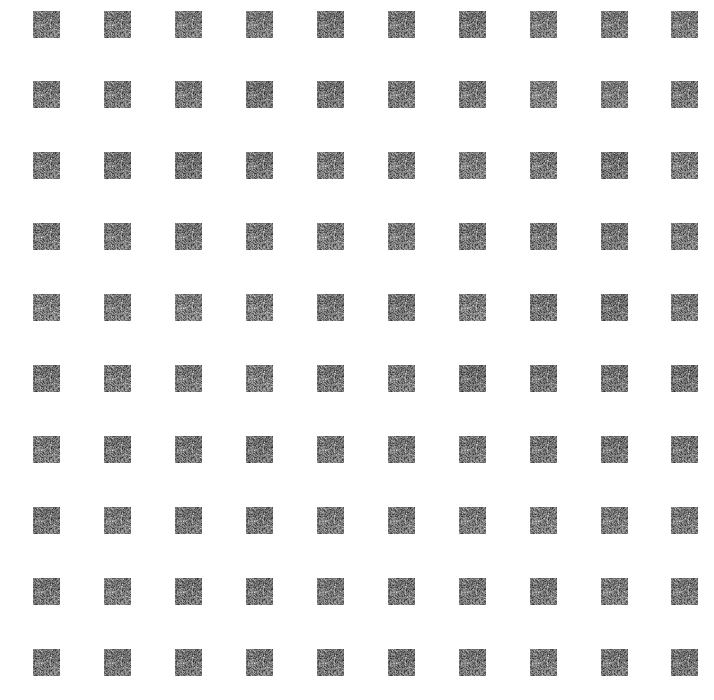

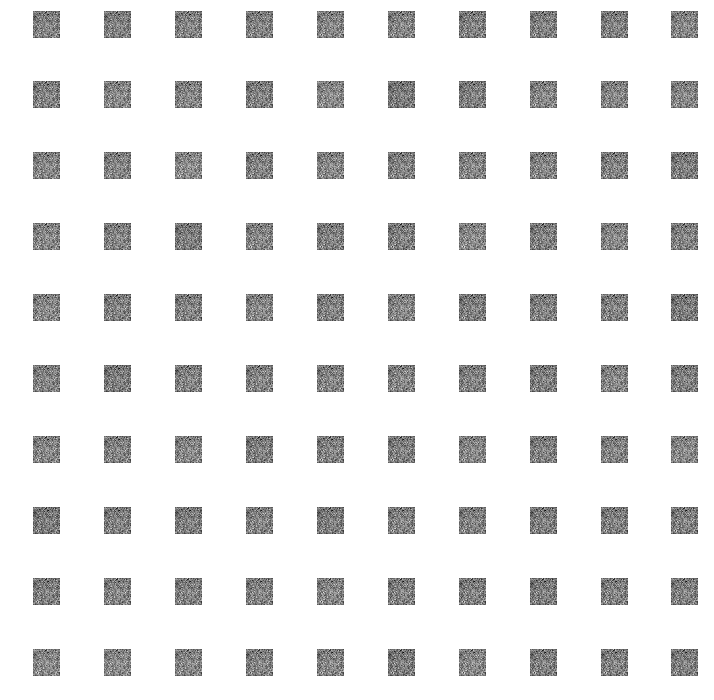

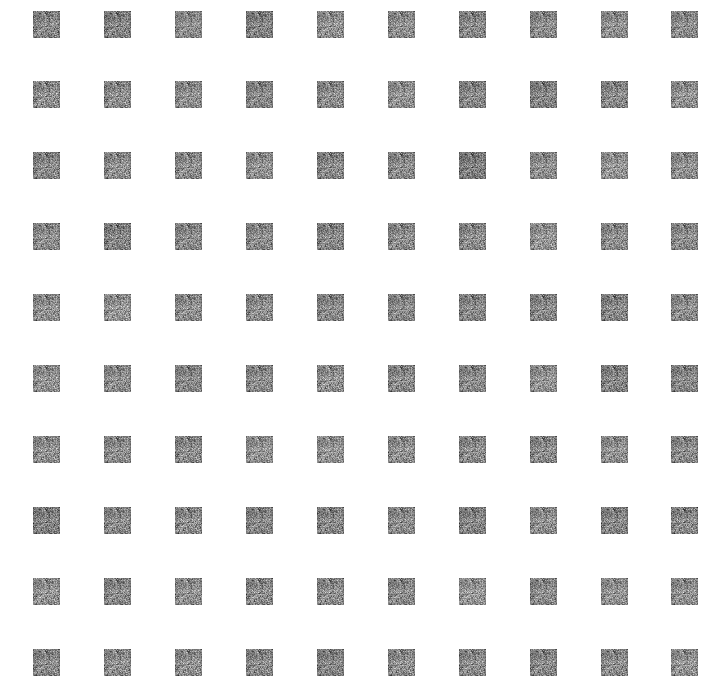

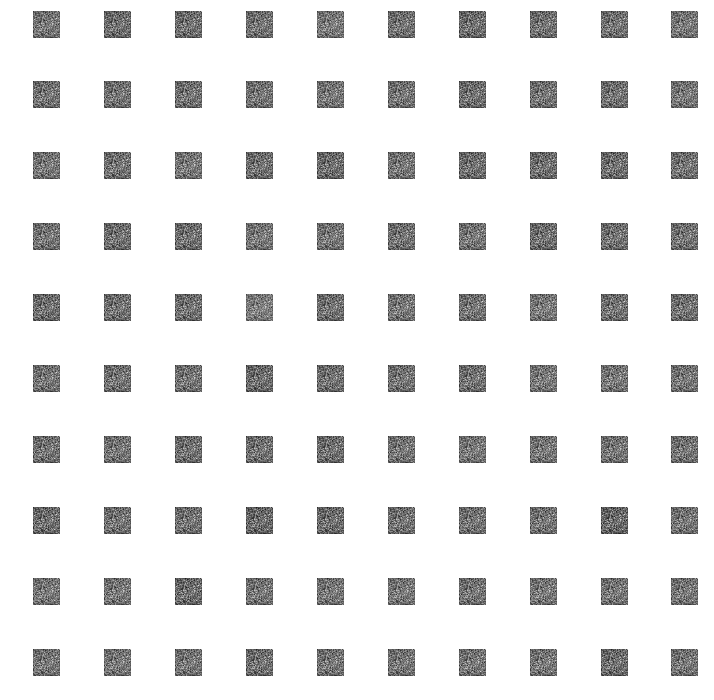

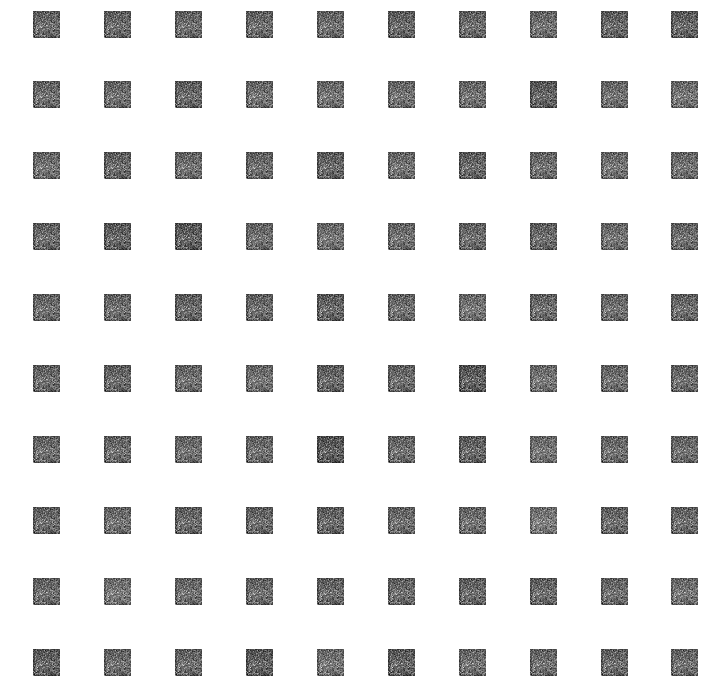

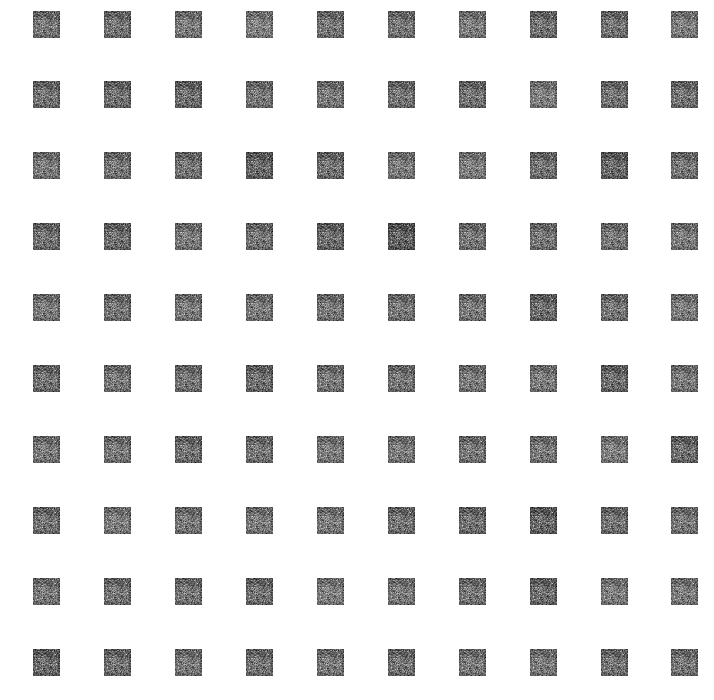

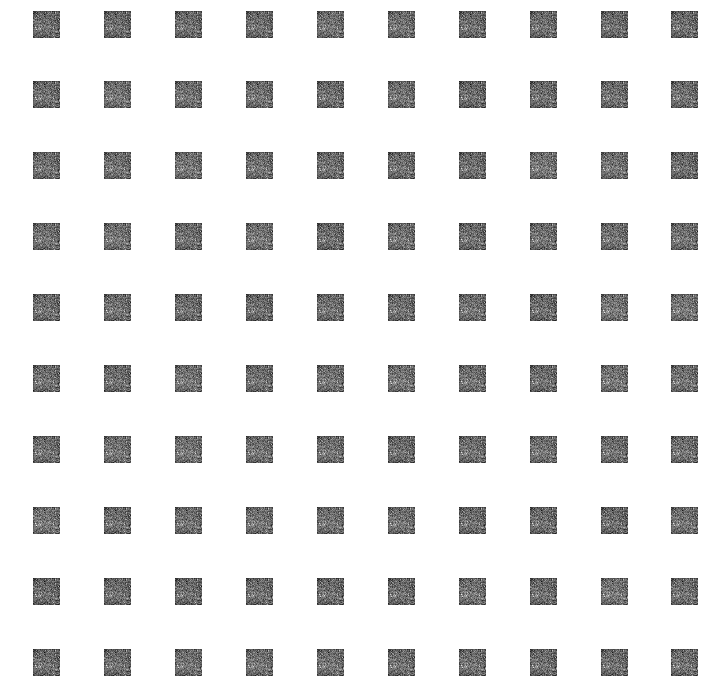

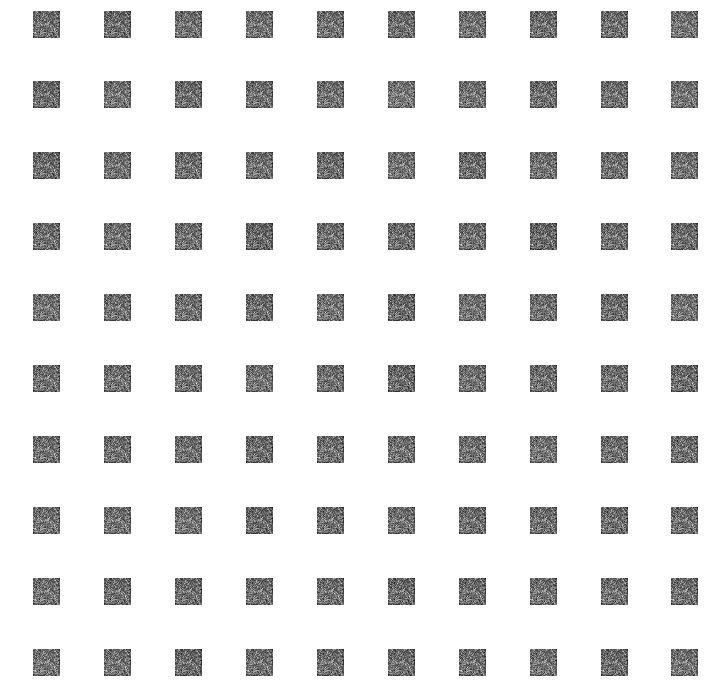

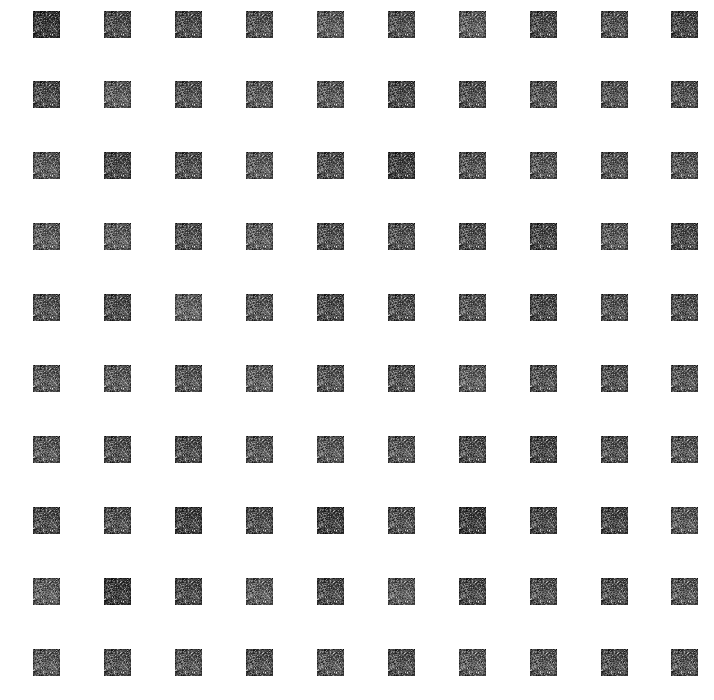

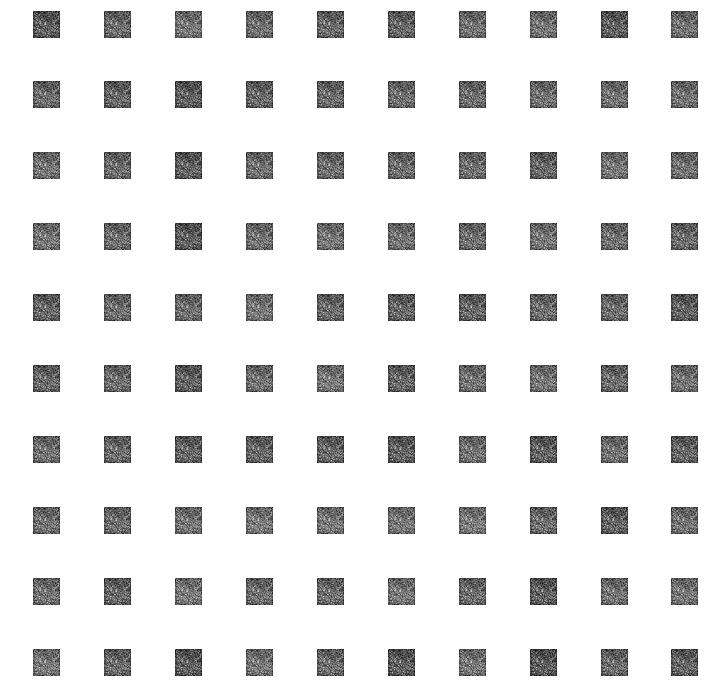

In [37]:
train(x_train, 50, 128)

In [ ]:
# Train the network
train(x_train, 20, 64)

  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Time since last epoch: 0.01 minutes.


  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------
Time since last epoch: 1.05 minutes.


  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------
Time since last epoch: 0.89 minutes.


  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------
Time since last epoch: 0.86 minutes.


  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------
Time since last epoch: 0.83 minutes.


  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------
Time since last epoch: 0.94 minutes.


  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------
Time since last epoch: 0.89 minutes.


  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------
Time since last epoch: 0.82 minutes.


  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------
Time since last epoch: 0.81 minutes.


  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------
Time since last epoch: 0.87 minutes.


  0%|          | 0/23 [00:00<?, ?it/s]

--------------- Epoch 11 ---------------
Time since last epoch: 1.10 minutes.


 39%|███▉      | 9/23 [00:20<00:34,  2.47s/it]

KeyboardInterrupt: 

Exception ignored in: <bound method tqdm.__del__ of  39%|███▉      | 9/23 [00:26<00:34,  2.47s/it]>
Traceback (most recent call last):
  File "/Users/john/.virtualenvs/newyorker/lib/python3.6/site-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/Users/john/.virtualenvs/newyorker/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/Users/john/.virtualenvs/newyorker/lib/python3.6/site-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/Users/john/.virtualenvs/newyorker/lib/python3.6/site-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
